### Packages

In [34]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order_combined as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### Loading ordered data from data_clean_order_text.ipynb

In [4]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [26]:
# Experimental data orderings on headlines TRAIN EXAMPLES
XB_train = rand_shuffled_text['cleaned_headline']
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# TRAIN LABELS
YB_train = rand_shuffled_text['superclass']
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['superclass']

In [29]:
YB_train[:100]

137393            SPORTS
167153           DIVORCE
167931     HOME & LIVING
207918     HOME & LIVING
177673          BUSINESS
               ...      
27842     HEALTHY LIVING
8902             LEISURE
147995          WELLNESS
173897          WELLNESS
135603          WELLNESS
Name: class, Length: 100, dtype: object

In [20]:
Y1_train[:100]

0     QUEER VOICES
1            WOMEN
2            WOMEN
3            WOMEN
4     QUEER VOICES
          ...     
95           WOMEN
96           WOMEN
97    BLACK VOICES
98    QUEER VOICES
99    BLACK VOICES
Name: class, Length: 100, dtype: object

In [21]:
Y2_train[:100]

0     ARTS
1     ARTS
2     ARTS
3     ARTS
4     ARTS
      ... 
95    ARTS
96    ARTS
97    ARTS
98    ARTS
99    ARTS
Name: class, Length: 100, dtype: object

In [22]:
Y3_train[:100]

92062     GENERAL POLITICS
43961     GENERAL POLITICS
53337     GENERAL POLITICS
43124     GENERAL POLITICS
21187     GENERAL POLITICS
                ...       
88359     GENERAL POLITICS
50484     GENERAL POLITICS
53332     GENERAL POLITICS
31127     GENERAL POLITICS
129773    GENERAL POLITICS
Name: class, Length: 100, dtype: object

In [23]:
Y4_train[:100]

146674    CULTURE & ARTS
178391    CULTURE & ARTS
171677    CULTURE & ARTS
134828    CULTURE & ARTS
180321    CULTURE & ARTS
               ...      
175688    CULTURE & ARTS
165071    CULTURE & ARTS
149233    CULTURE & ARTS
176447    CULTURE & ARTS
134825    CULTURE & ARTS
Name: class, Length: 100, dtype: object

In [24]:
Y5_train[:100]

92062    GENERAL POLITICS
2081     GENERAL POLITICS
8693     GENERAL POLITICS
51573    GENERAL POLITICS
44055    GENERAL POLITICS
               ...       
28681    GENERAL POLITICS
37855    GENERAL POLITICS
61560    GENERAL POLITICS
97174    GENERAL POLITICS
36405    GENERAL POLITICS
Name: class, Length: 100, dtype: object

In [25]:
Y_test[:100]

157485         PARENTING
120944      BLACK VOICES
154458           SCIENCE
208874       ENVIRONMENT
131064              ARTS
               ...      
159288         PARENTING
81676     HEALTHY LIVING
150079          WELLNESS
65346            LEISURE
113991        WEIRD NEWS
Name: class, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [30]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 77553


In [35]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# BASELINE ORDER - RAND SHUFFLED

In [31]:
# BASELINE TRAIN DATA
X_train = XB_train
Y_train = YB_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 217923


### Model training using embedding layer and RNN 

In [33]:
# basline model using embedding layers and simpleRNN
modelB = Sequential()
modelB.add(Embedding(total_words, 70, input_length=maxlen))
modelB.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
modelB.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
modelB.add(SimpleRNN(32, activation='tanh'))
modelB.add(Dropout(0.2))
modelB.add(Dense(9, activation='softmax'))
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            15254610  
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 42)               

In [36]:
modelB.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
historyB = modelB.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1048/1048 [==============================] - 157s 141ms/step - loss: 3.0471 - accuracy: 0.2406 - val_loss: 2.5921 - val_accuracy: 0.3311
Epoch 2/15
1048/1048 [==============================] - 145s 138ms/step - loss: 2.4833 - accuracy: 0.3646 - val_loss: 2.3243 - val_accuracy: 0.3981
Epoch 3/15
1048/1048 [==============================] - 147s 140ms/step - loss: 2.2053 - accuracy: 0.4337 - val_loss: 2.1585 - val_accuracy: 0.4480
Epoch 4/15
1048/1048 [==============================] - 146s 139ms/step - loss: 2.0317 - accuracy: 0.4755 - val_loss: 2.1047 - val_accuracy: 0.4639
Epoch 5/15
1048/1048 [==============================] - 144s 137ms/step - loss: 1.9076 - accuracy: 0.5044 - val_loss: 2.0937 - val_accuracy: 0.4707
Epoch 6/15
1048/1048 [==============================] - 150s 143ms/step - loss: 1.8119 - accuracy: 0.5290 - val_loss: 2.0264 - val_accuracy: 0.4828
Epoch 7/15
1048/1048 [==============================] - 150s 143ms/step - loss: 1.7220 - accuracy: 0.5497 - val_

Test loss and accuracy: 5.062496185302734 0.09211311489343643


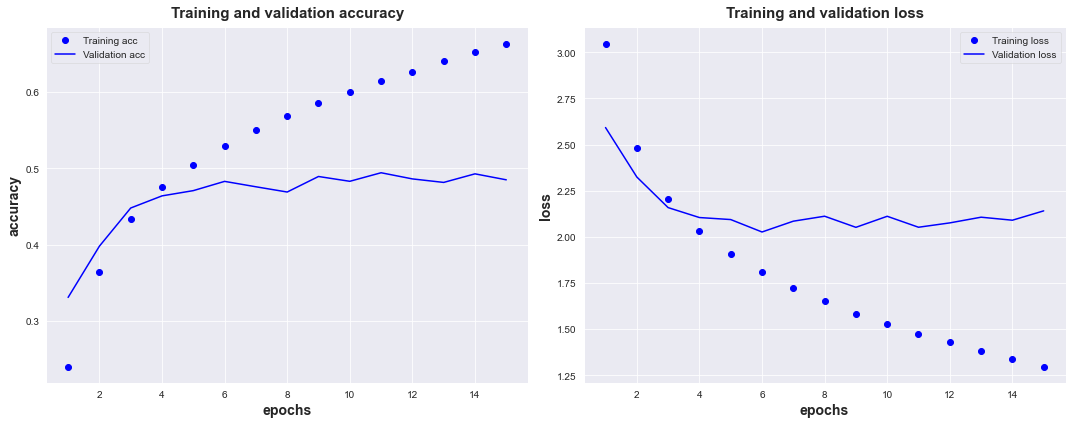

(41905,) (41905,)
[23  2 27 10  0] [38 20 40 26 38]
              precision    recall  f1-score   support

           0       0.01      0.00      0.00       310
           1       0.02      0.01      0.01       246
           2       0.02      0.02      0.02       914
           3       0.02      0.03      0.03      1212
           4       0.00      0.00      0.00       232
           5       0.03      0.07      0.05      1074
           6       0.01      0.00      0.01       723
           7       0.01      0.00      0.01       212
           8       0.01      0.00      0.00       662
           9       0.03      0.02      0.02       204
          10       0.02      0.00      0.01       298
          11       0.00      0.00      0.00       263
          12       0.04      0.01      0.02      1268
          13       0.25      0.29      0.27      7050
          14       0.00      0.00      0.00       283
          15       0.01      0.00      0.01       520
          16       0.07      

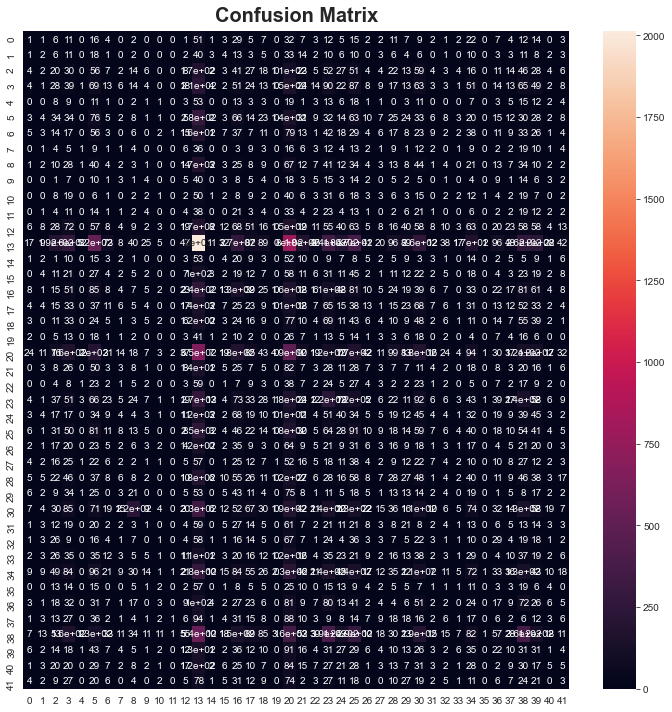

In [37]:
# evalute the model
test_loss, test_acc = modelB.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(historyB)

Y_pred = modelB.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: YES

Best training accuracy: 0.6650

Best validation accuracy: 0.4927

Test accuracy: 0.09

Training time: 37 m 1.1 s

# EXPERIMENT ORDER 1

In [78]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53538


### Model training using embedding layer and RNN 

In [79]:
# basline model using embedding layers and simpleRNN
model1 = Sequential()
model1.add(Embedding(total_words, 70, input_length=maxlen))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model1.add(SimpleRNN(32, activation='tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(9, activation='softmax'))
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 70)            3747660   
                                                                 
 bidirectional_18 (Bidirecti  (None, 20, 128)          17280     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 42)              

In [80]:
model1.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history1 = model1.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1310/1310 [==============================] - 102s 72ms/step - loss: 2.7662 - accuracy: 0.3069
Epoch 2/15
1310/1310 [==============================] - 105s 80ms/step - loss: 2.1611 - accuracy: 0.4439
Epoch 3/15
1310/1310 [==============================] - 110s 84ms/step - loss: 1.9394 - accuracy: 0.4953
Epoch 4/15
 679/1310 [==============>...............] - ETA: 49s - loss: 1.8127 - accuracy: 0.5254

In [ ]:
# evalute the model
test_loss, test_acc = model1.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history1)

Y_pred = model1.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 2

In [ ]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

### Model training using embedding layer and RNN

In [ ]:
# basline model using embedding layers and simpleRNN
model2 = Sequential()
model2.add(Embedding(total_words, 70, input_length=maxlen))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model2.add(SimpleRNN(32, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Densee(9, activation='softmax'))
model2.summary()

In [ ]:
model2.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

In [ ]:
# evalute the model
test_loss, test_acc = model2.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2)

Y_pred = model2.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 3

In [ ]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

### Model training using embedding layer and RNN

In [ ]:
# basline model using embedding layers and simpleRNN
model3 = Sequential()
model3.add(Embedding(total_words, 70, input_length=maxlen))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model3.add(SimpleRNN(32, activation='tanh'))
model3.add(Dropout(0.2))
model3.add(Dense(9, activation='softmax'))
model3.summary()

In [ ]:
model3.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history3 = model3.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

In [ ]:
# evalute the model
test_loss, test_acc = model3.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history3)

Y_pred = model3.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 4

In [ ]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

### Model training using embedding layer and RNN (Baseline)

In [ ]:
# basline model using embedding layers and simpleRNN
model4 = Sequential()
model4.add(Embedding(total_words, 70, input_length=maxlen))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model4.add(SimpleRNN(32, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(9, activation='softmax'))
model4.summary()

In [ ]:
model4.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history4 = model4.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

In [ ]:
# evalute the model
test_loss, test_acc = model4.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history4)

Y_pred = model4.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 5

In [ ]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

### Model training using embedding layer and RNN (Baseline)

In [ ]:
# basline model using embedding layers and simpleRNN
model5 = Sequential()
model5.add(Embedding(total_words, 70, input_length=maxlen))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model5.add(SimpleRNN(32, activation='tanh'))
model5.add(Dropout(0.2))
model5.add(Dense(9, activation='softmax'))
model5.summary()

In [ ]:
model5.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history5 = model5.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

In [ ]:
# evalute the model
test_loss, test_acc = model5.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history5)

Y_pred = model5.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time: